# Predicting Pitcher Velocity Differential

In baseball, variations in pitch shape and velocity are the primary tools pitchers use to deceive hitters and generate strikeouts. The inherent difference in velocity between a fastball and a breaking ball is tied to the trajectory of the pitch. By understanding how pitch characteristics interact with each other, we can create a model designed to predict the velocity differential between a pitcher’s primary fastball (defined as an average of their four-seamers, two-seamers, and sinkers) their breaking balls. Establishing a per-pitcher fastball velocity baseline and engineering features representing the differences in pitch characteristics (e.g., break, release point, spin) between these fastballs and breaking balls, a we can develop said model. Identifying which engineered pitch characteristic differentials (such as vertical break difference) most significantly influence velocity separation is crucial for guiding pitchers in optimizing their repertoire and enhancing deception by disrupting hitter timing and choosing specific pitch sequences. 

## Data Preparation and EDA

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib
print(pd.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.2.2
Mounted at /content/drive


In [2]:
#df = pd.read_csv("/Users/josephndigiovanni/Downloads/Solutions Data Project/Solutions Data Project - Data.csv")
df = pd.read_csv("/content/drive/MyDrive/Solutions Data Project - Data.csv")

In [3]:
df.tail()

,game_id,date,season,batter_id,batter,bats,pitcher_id,pitcher,throws,inning,...,release_z,extension,haa,vaa,hra,vra,exit_velo,launch_angle,spray_angle,hit_spin_rate
3108201,631002,2020-09-27,2020,474832,Brandon Belt,L,657612,Tim Hill,L,8,...,2.8815,6.7838,2.3418,-2.2295,5.8692,3.2116,NaN,NaN,NaN,NaN
3108202,631002,2020-09-27,2020,446334,Evan Longoria,R,641941,Emilio Pagan,R,8,...,5.6452,6.5163,-4.2553,-7.4790,-3.4908,-1.5189,NaN,NaN,NaN,NaN
3108203,631002,2020-09-27,2020,446334,Evan Longoria,R,641941,Emilio Pagan,R,8,...,5.6857,6.5186,-1.1810,-5.6475,-2.1743,-3.5617,NaN,NaN,NaN,NaN
3108204,631002,2020-09-27,2020,594824,Greg Garcia,L,592332,Kevin Gausman,R,9,...,6.0731,6.3954,-2.0767,-6.0290,-4.3958,-3.4054,NaN,NaN,NaN,NaN
3108205,631002,2020-09-27,2020,596103,Austin Slater,R,572096,Trevor Rosenthal,R,9,...,6.1403,6.3351,-0.5547,-6.1910,-1.8239,-4.2790,NaN,NaN,NaN,NaN


In [5]:
df.head()
df.shape[0]

3108206

In [6]:
df.describe()

,game_id,season,batter_id,pitcher_id,inning,pitch_num,balls,strikes,outs,release_velo,...,release_z,extension,haa,vaa,hra,vra,exit_velo,launch_angle,spray_angle,hit_spin_rate
count,3.108206e+06,3.108206e+06,3.108206e+06,3.108206e+06,3.108206e+06,3.108206e+06,3.108206e+06,3.108206e+06,3.108206e+06,3.107690e+06,...,3.107731e+06,3.101834e+06,3.107731e+06,3.107731e+06,3.107731e+06,3.107731e+06,1.029415e+06,1.030139e+06,1.030141e+06,976253.000000
mean,6.849192e+05,2.022289e+03,6.189832e+05,6.168812e+05,4.936492e+00,2.914538e+00,8.798455e-01,9.004519e-01,9.808311e-01,8.892633e+01,...,5.800984e+00,6.375256e+00,-7.815272e-01,-6.535053e+00,-1.040687e+00,-1.310170e+00,8.205975e+01,1.683437e+01,3.663704e+00,3651.994496
std,4.544692e+04,1.275628e+00,6.110383e+04,6.191500e+04,2.590662e+00,1.737640e+00,9.672993e-01,8.282899e-01,8.179226e-01,6.077097e+00,...,5.415324e-01,4.591473e-01,2.258247e+00,1.953418e+00,2.612538e+00,1.434792e+00,1.589423e+01,3.307093e+01,8.048524e+01,2218.089396
min,6.300990e+05,2.020000e+03,4.053950e+05,4.053950e+05,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.013860e+01,...,7.594000e-01,2.587300e+00,-1.320520e+01,-3.476970e+01,-1.254070e+01,-1.239900e+01,3.871000e-01,-8.987160e+01,-1.799961e+02,0.001500
25%,6.339840e+05,2.021000e+03,5.926260e+05,5.927910e+05,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.462650e+01,...,5.535900e+00,6.068900e+00,-2.332600e+00,-7.811100e+00,-2.947500e+00,-2.273500e+00,7.250450e+01,-5.349350e+00,-3.554610e+01,1916.689900
50%,6.630290e+05,2.022000e+03,6.418570e+05,6.404550e+05,5.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.982460e+01,...,5.841300e+00,6.384700e+00,-8.740000e-01,-6.346300e+00,-1.805100e+00,-1.411900e+00,8.192570e+01,1.951340e+01,3.809000e-01,3291.698300
75%,7.185550e+05,2.023000e+03,6.658620e+05,6.642850e+05,7.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.380500e+01,...,6.133800e+00,6.675700e+00,6.174000e-01,-5.082900e+00,9.555000e-01,-4.674000e-01,9.428330e+01,4.123115e+01,4.248330e+01,5115.113400
max,7.472240e+05,2.024000e+03,8.089820e+05,8.140050e+05,1.600000e+01,1.900000e+01,4.000000e+00,3.000000e+00,2.000000e+00,1.055179e+02,...,8.112200e+00,1.317800e+01,1.113790e+01,4.152300e+00,1.051290e+01,2.278540e+01,1.223766e+02,8.987520e+01,1.799997e+02,16382.061700


In [7]:
print(df.columns)

Index(['game_id', 'date', 'season', 'batter_id', 'batter', 'bats',
       'pitcher_id', 'pitcher', 'throws', 'inning', 'half_inning', 'tto',
       'pitch_num', 'balls', 'strikes', 'outs', 'pitch_type', 'release_velo',
       'spin_rate', 'spin_direction', 'break_x', 'break_z', 'induced_break_z',
       'location_x', 'location_z', 'release_x', 'release_z', 'extension',
       'haa', 'vaa', 'hra', 'vra', 'exit_velo', 'launch_angle', 'spray_angle',
       'hit_spin_rate'],
      dtype='object')


### As I was doing an error analysis on the model in my first run through, I noticed the model's worst predicitions were on position players pitching. The below code block fixes that, but I saved the initial error analysis.

In [8]:
import pandas as pd

# ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# sort the dataframe first by pitcher name, then chronologically by date
df = df.sort_values(by=['pitcher', 'date'], ascending=True)
df.head()

,game_id,date,season,batter_id,batter,bats,pitcher_id,pitcher,throws,inning,...,release_z,extension,haa,vaa,hra,vra,exit_velo,launch_angle,spray_angle,hit_spin_rate
9168,632678,2021-08-30,2021,596115,Trevor Story,R,669935,A.J. Alexy,R,2,...,6.0437,6.8057,-1.3469,-3.3524,-2.5316,-1.4606,NaN,NaN,NaN,NaN
14656,632678,2021-08-30,2021,641857,Ryan McMahon,L,669935,A.J. Alexy,R,2,...,5.9863,6.8046,-0.0358,-4.5756,-1.1728,-1.8175,NaN,NaN,NaN,NaN
27344,632678,2021-08-30,2021,656582,Connor Joe,R,669935,A.J. Alexy,R,3,...,5.9631,6.7971,-1.6475,-5.9124,-2.5962,-3.5080,NaN,NaN,NaN,NaN
65311,632678,2021-08-30,2021,553869,Elias Diaz,R,669935,A.J. Alexy,R,5,...,5.8853,6.5862,-2.5558,-9.9837,-0.9794,-1.6016,NaN,NaN,NaN,NaN
83915,632678,2021-08-30,2021,543068,C.J. Cron,R,669935,A.J. Alexy,R,2,...,5.9733,6.7674,-0.0062,-4.4093,-1.0944,-1.8879,NaN,NaN,NaN,NaN


In [9]:
df.isnull().sum()

,0
game_id,0
date,0
season,0
batter_id,0
batter,0
bats,0
pitcher_id,0
pitcher,0
throws,0
inning,0


## Data Cleaning

First I want to remove any position players pitching. I cast a wide net by assuming anyone who threw less that 300 pitches AND didn't exceed 86mph on any pitch. This may snag a few guys who had a cup of coffee in the majors and ony happened to throw a few breaking balls, but removing outliers benefits the model more than harming it.

In [10]:
# Calculate total pitches thrown by each pitcher
pitcher_stats = df.groupby('pitcher_id').agg(
    pitcher_name=('pitcher', 'first'), # Get pitcher name
    total_pitches=('pitcher_id', 'size'),      # Count pitches
    max_velo=('release_velo', 'max')   # Get max velocity
).reset_index()

MIN_PITCHES_THRESHOLD = 300
MIN_MAX_VELO_THRESHOLD = 86.0 # MPH

pitchers_to_remove_df = pitcher_stats[
    (pitcher_stats['total_pitches'] < MIN_PITCHES_THRESHOLD) &
    (pitcher_stats['max_velo'] < MIN_MAX_VELO_THRESHOLD)
]

pitcher_ids_to_remove = pitchers_to_remove_df['pitcher_id']
df = df[~df['pitcher_id'].isin(pitcher_ids_to_remove)].copy()

print(f"\nInitial number of unique pitchers: {pitcher_stats['pitcher_id'].nunique()}")
print(f"Number of pitchers removed: {len(pitcher_ids_to_remove)}")
print(f"After filtering for pitchers (low volume AND low max velo removed):")
print(f"Number of rows remaining: {len(df)}")
print(f"Number of unique pitchers remaining: {df['pitcher_id'].nunique()}")


Initial number of unique pitchers: 1664
Number of pitchers removed: 157
After filtering for pitchers (low volume AND low max velo removed):
Number of rows remaining: 3102683
Number of unique pitchers remaining: 1507


In [11]:
df = df.drop(['game_id', 'batter_id', 'batter', 'bats',
              'throws', 'half_inning', 'tto', 'outs', 'balls', 'extension',
              'strikes', 'launch_angle', 'spray_angle', 'hit_spin_rate', 'vra', 'hra',
              'exit_velo', 'pitch_num', 'season'], axis=1)

In [12]:
df.isnull().sum()

,0
date,0
pitcher_id,0
pitcher,0
inning,0
pitch_type,0
release_velo,505
spin_rate,20963
spin_direction,20962
break_x,474
break_z,477


In [13]:
# drop rows with columns with least NaNs
cols_few_nans = ['release_velo', 'break_x', 'break_z', 'induced_break_z',
                 'location_x', 'location_z', 'release_x', 'release_z',
                 'haa', 'vaa']
df_processed = df.dropna(subset=cols_few_nans)
print(f"Rows before dropping few NaNs: {len(df)}")
print(f"Rows after dropping few NaNs:  {len(df_processed)}")

Rows before dropping few NaNs: 3102683
Rows after dropping few NaNs:  3102155


### The plan is to use a Random Forest Regressor, which can handle missing values, but because spinrate and spin axis had so many more missing values, I'm going to impute averages.

In [14]:
# impute spin_rate and spin_direction using per-pitcher median
print(f"\nNaNs before spin impute:\n{df_processed[['spin_rate', 'spin_direction']].isnull().sum()}")

# calculate median per pitcher only once
pitcher_median_spin = df_processed.groupby('pitcher_id')[['spin_rate', 'spin_direction']].transform('median')

# fill NaNs using the calculated pitcher-specific medians
df_processed['spin_rate'].fillna(pitcher_median_spin['spin_rate'], inplace=True)
df_processed['spin_direction'].fillna(pitcher_median_spin['spin_direction'], inplace=True)

# check for remaining NaNs (only if a pitcher had all NaNs for spin)
print(f"\nNaNs after spin impute:\n{df_processed[['spin_rate', 'spin_direction']].isnull().sum()}")

# handle any rare remaining NaNs (pitchers with zero non-NaN spin data) by dropping or global median
remaining_nans = df_processed[['spin_rate', 'spin_direction']].isnull().sum().sum()
if remaining_nans > 0:
    print(f"Found {remaining_nans} remaining NaNs after median impute, likely from pitchers with no spin data. Dropping these rows.")
    df_processed.dropna(subset=['spin_rate', 'spin_direction'], inplace=True)


NaNs before spin impute:
spin_rate         20496
spin_direction    20495
dtype: int64

NaNs after spin impute:
spin_rate         0
spin_direction    0
dtype: int64


<ipython-input-14-bfa46bbbe7b4>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['spin_rate'].fillna(pitcher_median_spin['spin_rate'], inplace=True)
<ipython-input-14-bfa46bbbe7b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['spin_rate'].fillna(pitcher_median_spin['spin_rate'], inplace=True)
<ipython-input-14-bfa

In [15]:
df_processed['pitch_type'].unique()

array(['FF', 'SL', 'CH', 'CB', 'CT', 'SI', 'SP', 'SW', 'SV', 'EP', 'KN'],
      dtype=object)

In [16]:
df_final = df_processed # Final DataFrame ready for feature engineering

In [17]:
# define pitch type categories
fastball_types = ['FF', 'SI', 'FT'] # Four-seam, Sinker, Two-seam

# cutter (FC) handled separately below

breaking_ball_types = ['SL', 'CB', 'KN', 'ST', 'SV', 'CS', 'SW'] # Slider, Curve, Knuckle Curve, Sweeper, Slurve, Slow Curve

# also want to predict the differential for Cutters (FC), which are generally slower
target_pitch_types = breaking_ball_types + ['CT']

In [18]:
# filter for fastball pitches (excluding cutters for this average calculation)
df_fastballs = df_final[df_final['pitch_type'].isin(fastball_types)].copy()

# calculate the avg release velocity for fastballs per pitcher_id
pitcher_avg_ff_velo = df_fastballs.groupby('pitcher_id')['release_velo'].transform('mean')

# add this average fastball velocity back to the main DataFrame
df_final['avg_ff_velo'] = df_final.groupby('pitcher_id')['release_velo'].transform(
    lambda x: x[df_final.loc[x.index, 'pitch_type'].isin(fastball_types)].mean()
)

<ipython-input-18-ef61f246397d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['avg_ff_velo'] = df_final.groupby('pitcher_id')['release_velo'].transform(


In [19]:
# Keep only rows that are cutters or breaking balls
df_target = df_final[df_final['pitch_type'].isin(target_pitch_types)].copy()

# Calculate the velocity differential (target variable)
# It's the pitch's velocity minus the pitcher's average fastball velocity
df_target['velocity_diff'] = df_target['release_velo'] - df_target['avg_ff_velo']

initial_rows = len(df_target)
df_target.dropna(subset=['avg_ff_velo', 'velocity_diff'], inplace=True)
final_rows = len(df_target)
if initial_rows > final_rows:
    print(f"Dropped {initial_rows - final_rows} rows due to missing avg_ff_velo (pitchers likely threw no fastballs).")

# Display the first few rows with the new columns
print("DataFrame filtered for target pitches with calculated avg_ff_velo and velocity_diff:")
print(df_target[['pitcher_id', 'pitch_type', 'release_velo', 'avg_ff_velo', 'velocity_diff']].head())

# Display value counts for pitch types included
print("\nPitch types included in the target DataFrame:")
print(df_target['pitch_type'].value_counts())

Dropped 1129 rows due to missing avg_ff_velo (pitchers likely threw no fastballs).
DataFrame filtered for target pitches with calculated avg_ff_velo and velocity_diff:
        pitcher_id pitch_type  release_velo  avg_ff_velo  velocity_diff
65311       669935         SL       78.8568     93.55524      -14.69844
103036      669935         SL       82.0707     93.55524      -11.48454
138046      669935         SL       81.9959     93.55524      -11.55934
361318      669935         SL       83.0447     93.55524      -10.51054
374956      669935         SL       81.6060     93.55524      -11.94924

Pitch types included in the target DataFrame:
pitch_type
SL    520620
CB    285129
CT    231613
SW    130704
SV      9714
KN      1248
Name: count, dtype: int64


To keep it simple, I dropped all columns that weren’t directly related to the pitch characteristics, only leaving inning, date, and pitcher name/id as non-numeric predictors. 

To ensure we were only looking at pitchers, I filtered anybody who had both less than 300 pitches and never threw a pitch exceeding 86 mph. While not 100% perfect, this filtered out nearly all position players pitching in unserious game situations. While only a fraction of the dataset, this removed about 157 unique players who pitched (9% of total pitchers). I then averaged the velocities of four-seamers, two-seamers, and sinkers per pitcher to establish each pitcher’s baseline fastball velocity. Using that baseline, I calculated the velocity differential of all breaking balls on a per-pitcher basis. I chose to isolate cutters in their own category because they sit in a weird spot between fastballs and breaking balls, but they were still added as a target variable. The distribution of the targeted breaking balls after the cleaning (above) shows that sliders were most common, followed by curveballs and cutters. It should be noted that cutters have a unique high velocity profile with less vertical movement when compared to the other breaking balls.

Finally, the metrics for velocity, break, location, release point, and approach angle all had roughly 500 NaN values; those rows dropped, given they only constituted 0.01% of the dataset. Spin rate and spin axis had roughly 21,000 NaN values each, which were imputed with median values to keep the cleaning simple. Had the amount of missing values for a column exceeded 2% of the total, I would have opted for a kNN imputation to maintain data quality.

## Feature Selection and Model Creation

Given the objective to minimize residuals between predicted and actual velocity differentials, I opted to use a Random Forest Regressor (RFR) model. RFRs are ideal for structured tabular datasets and they do well with nonlinear relationships, which I anticipated I would run into given how complicated the movement profiles of individual pitches can be.  While other powerful models like Gradient Boosting Machines (e.g., XGBoost, which was later used for validation) or Support Vector Regression could be considered, RFR offered a strong balance of performance, interpretability, and relative ease of implementation for this project. I trained the first RFR model strictly on the raw pitch characteristics.


In [20]:
# Feature Selection
features = ['avg_ff_velo', 'pitch_type', 'spin_rate', 'spin_direction',
            'break_x', 'break_z', 'release_x', 'release_z']
target = 'velocity_diff'

# Create the feature matrix X and target vector y
X = df_target[features].copy()
y = df_target[target]

print("Selected Features (X shape):", X.shape)
print("Target Variable (y shape):", y.shape)
print("Features used:", features)

Selected Features (X shape): (1179028, 8)
Target Variable (y shape): (1179028,)
Features used: ['avg_ff_velo', 'pitch_type', 'spin_rate', 'spin_direction', 'break_x', 'break_z', 'release_x', 'release_z']


In [21]:
# Encode Categorical Features
categorical_cols = ['pitch_type']
numeric_cols = [col for col in features if col not in categorical_cols]

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the relevant columns in X and transform
encoded_cats = encoder.fit_transform(X[categorical_cols])

# Create a new DataFrame with the encoded columns
encoded_cols = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cols, index=X.index)

# Combine numeric features and encoded categorical features
X_processed = pd.concat([X[numeric_cols], encoded_df], axis=1)

print("\nShape of processed features (X_processed):", X_processed.shape)
print(X_processed.head())


Shape of processed features (X_processed): (1179028, 13)
        avg_ff_velo  spin_rate  spin_direction  break_x  break_z  release_x  \
65311      93.55524  2415.8617         66.4314  -8.2815 -44.5781     1.0877   
103036     93.55524  2261.6817         74.7261  -6.5248 -40.2585     1.0649   
138046     93.55524  2284.7046         65.8126  -6.4143 -42.2547     1.1443   
361318     93.55524  2271.9012         95.2966  -6.1250 -40.1293     1.1589   
374956     93.55524  2225.7932         71.8622  -8.1818 -36.2438     1.3095   

        release_z  pitch_type_CB  pitch_type_CT  pitch_type_KN  pitch_type_SL  \
65311      5.8853            0.0            0.0            0.0            1.0   
103036     5.9504            0.0            0.0            0.0            1.0   
138046     6.0027            0.0            0.0            0.0            1.0   
361318     5.9072            0.0            0.0            0.0            1.0   
374956     6.0225            0.0            0.0            0.0

In [22]:
df_target.isnull().sum()

,0
date,0
pitcher_id,0
pitcher,0
inning,0
pitch_type,0
release_velo,0
spin_rate,0
spin_direction,0
break_x,0
break_z,0


In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42) #80/20 split

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size:  {X_test.shape[0]} samples")


Training set size: 943222 samples
Testing set size:  235806 samples


In [24]:
# model training ---
print("\nInitiating Random Forest Regressor training...")

# initialize the RF Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
                                 oob_score=True,
                                 verbose=1)

# record start time
start_time = time.time()

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Record end time and calculate duration
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")

# Display the Out-Of-Bag score (an estimate of the R^2 on unseen data)
if hasattr(rf_model, 'oob_score_'):
    print(f"Model Out-Of-Bag (OOB) R^2 score: {rf_model.oob_score_:.4f}")


Initiating Random Forest Regressor training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished



Training completed in 208.43 seconds.
Model Out-Of-Bag (OOB) R^2 score: 0.9352


R^2 > 0.9

In [25]:


# model evaluation
print("\nEvaluating model performance on the test set...")

# make predictions on the test set
y_pred = rf_model.predict(X_test)

# calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Evaluation Metrics:")
print(f"  Mean Absolute Error (MAE):      {mae:.4f} (MPH difference)")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f} (MPH difference)")
print(f"  R-squared (R²):                 {r2:.4f}")


Evaluating model performance on the test set...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.8s



Test Set Evaluation Metrics:
  Mean Absolute Error (MAE):      0.8430 (MPH difference)
  Root Mean Squared Error (RMSE): 1.1845 (MPH difference)
  R-squared (R²):                 0.9371


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.3s finished


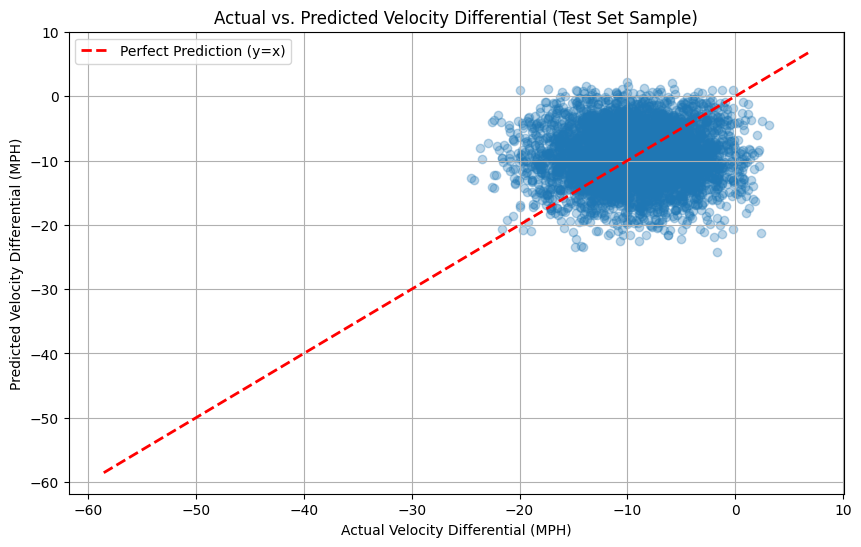

In [26]:
plt.figure(figsize=(10, 6))
sample_indices = np.random.choice(X_test.index, size=min(5000, len(X_test)), replace=False)
plt.scatter(y_test.loc[sample_indices], y_pred[y_test.index.isin(sample_indices)], alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction (y=x)')
plt.xlabel("Actual Velocity Differential (MPH)")
plt.ylabel("Predicted Velocity Differential (MPH)")
plt.title("Actual vs. Predicted Velocity Differential (Test Set Sample)")
plt.legend()
plt.grid(True)
plt.show()

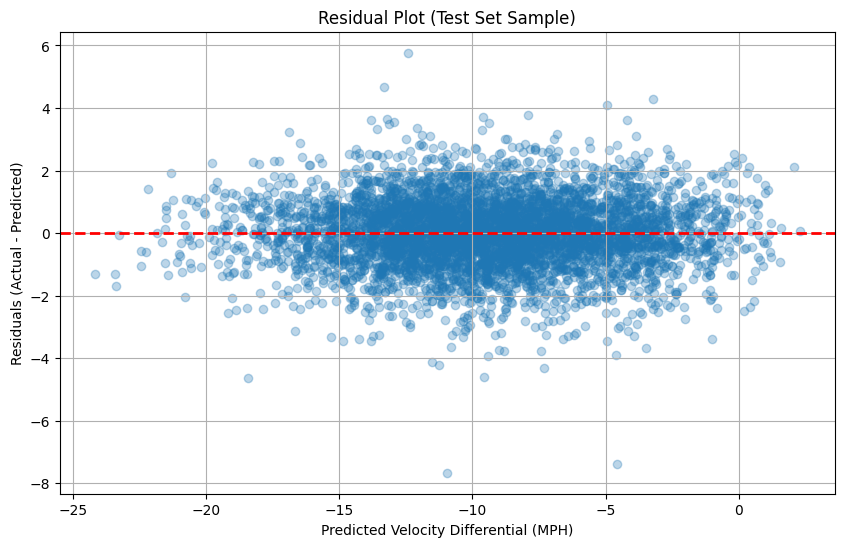

In [27]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred[y_test.index.isin(sample_indices)], residuals.loc[sample_indices], alpha=0.3)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Velocity Differential (MPH)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Test Set Sample)")
plt.grid(True)
plt.show()


Top 15 Feature Importances:
           Feature  Importance
4          break_z    0.689990
8    pitch_type_CT    0.082421
0      avg_ff_velo    0.080097
2   spin_direction    0.038199
1        spin_rate    0.029423
5        release_x    0.022206
6        release_z    0.022002
3          break_x    0.021327
12   pitch_type_SW    0.009753
10   pitch_type_SL    0.002869
7    pitch_type_CB    0.001294
11   pitch_type_SV    0.000372
9    pitch_type_KN    0.000049


<ipython-input-28-5a1bf588f060>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


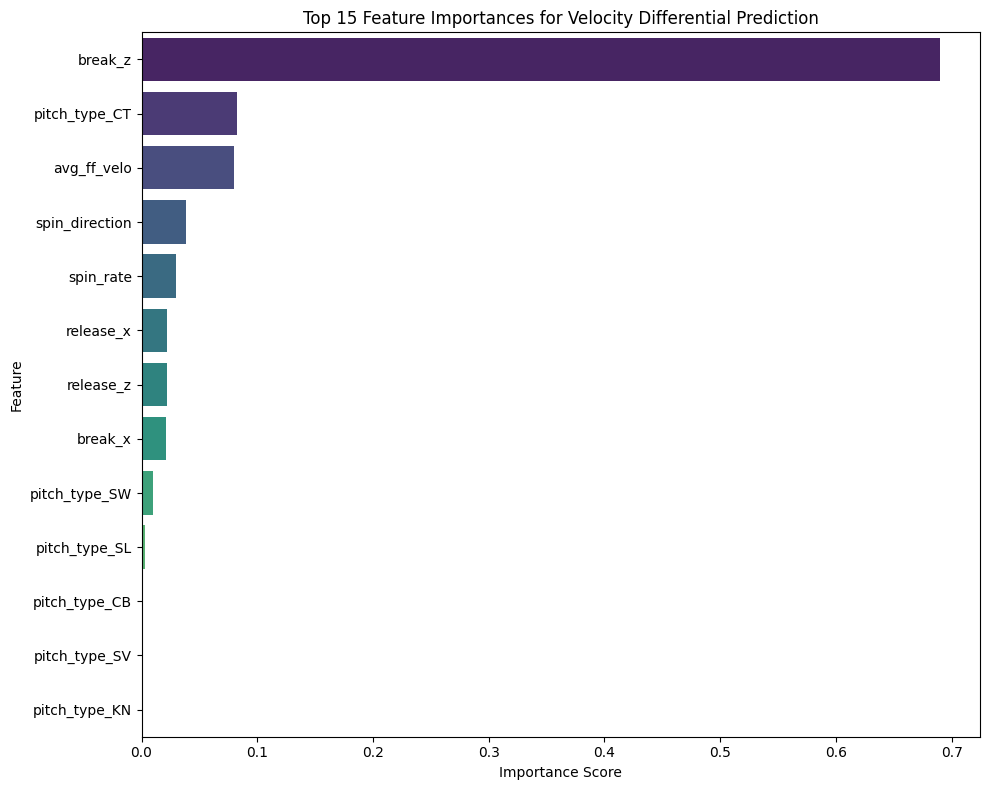

In [28]:
# Feature Importance
importances = rf_model.feature_importances_
feature_names = X_processed.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 15 Feature Importances:")
print(feature_importance_df.head(15))

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances for Velocity Differential Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### At this point, I'm seeing a couple things.

Firstly, despite a promising R^2 score, the predicted vs. actual difference plot is yielding a cloud cluster instead of following the ideal y=x prediction line. The residual plot is a little better but not by much.

Looking at feature importance, unsuprisingly vertical break is far and away the best predictor, followed by average fastball velocity.

In [29]:
# Calculate Pitcher Averages for Fastball
# Define fastball types (FF, SI, FT)
fastball_types = ['FF', 'SI', 'FT']
df_fastballs_only = df_final[df_final['pitch_type'].isin(fastball_types)].copy()

# Columns to average for the fastball baseline
baseline_cols = ['spin_rate', 'spin_direction', 'break_x', 'break_z',
                 'release_x', 'release_z']

# Calculate mean for each column per pitcher using transform
pitcher_ff_averages = {}
for col in baseline_cols:
    avg_col_name = f'avg_ff_{col}'
    averages = df_fastballs_only.groupby('pitcher_id')[col].transform('mean')
    pitcher_ff_averages[avg_col_name] = averages
    print(f"  Calculated {avg_col_name}")

# convert the dictionary of series to a DataFrame, aligned by index
pitcher_ff_averages_df = pd.DataFrame(pitcher_ff_averages, index=df_fastballs_only.index)

  Calculated avg_ff_spin_rate
  Calculated avg_ff_spin_direction
  Calculated avg_ff_break_x
  Calculated avg_ff_break_z
  Calculated avg_ff_release_x
  Calculated avg_ff_release_z


In [30]:
# Merge Averages into the Target DataFrame
# add the averages to the original df_final
for col_name, avg_series in pitcher_ff_averages.items():
    # Map the averages based on pitcher_id
    df_final[col_name] = df_final.groupby('pitcher_id')[col].transform(
        lambda x: x[df_final.loc[x.index, 'pitch_type'].isin(fastball_types)].mean()
        )

target_pitch_types = df_target['pitch_type'].unique() # Get pitch types already in df_target
all_avg_cols = [f'avg_ff_{col}' for col in baseline_cols] + ['avg_ff_velo']
cols_to_keep = df_target.columns.tolist() + [col for col in all_avg_cols if col not in df_target.columns]

# Re-create df_target from df_final to include the new average columns
df_target_enriched = df_final[df_final['pitch_type'].isin(target_pitch_types)].copy()

# Recalculate velocity_diff just to be safe (if df_final was source)
if 'avg_ff_velo' not in df_target_enriched.columns:
     df_target_enriched['avg_ff_velo'] = df_final.groupby('pitcher_id')['release_velo'].transform(
    lambda x: x[df_final.loc[x.index, 'pitch_type'].isin(fastball_types)].mean()
    )
df_target_enriched['velocity_diff'] = df_target_enriched['release_velo'] - df_target_enriched['avg_ff_velo']


# Handle potential NaNs introduced if a pitcher had fastballs but maybe ALL NaNs for one specific feature
initial_rows = len(df_target_enriched)
df_target_enriched.dropna(subset=all_avg_cols + ['velocity_diff'], inplace=True)
final_rows = len(df_target_enriched)
if initial_rows > final_rows:
    print(f"Dropped {initial_rows - final_rows} rows due to missing baseline averages after merge.")

print("Target DataFrame enriched with average fastball characteristics.")
print(df_target_enriched[['pitcher_id', 'pitch_type', 'release_velo', 'avg_ff_velo', 'avg_ff_spin_rate', 'avg_ff_release_x']].head())

<ipython-input-30-946bfa8a53ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col_name] = df_final.groupby('pitcher_id')[col].transform(
<ipython-input-30-946bfa8a53ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col_name] = df_final.groupby('pitcher_id')[col].transform(
<ipython-input-30-946bfa8a53ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Dropped 1129 rows due to missing baseline averages after merge.
Target DataFrame enriched with average fastball characteristics.
        pitcher_id pitch_type  release_velo  avg_ff_velo  avg_ff_spin_rate  \
65311       669935         SL       78.8568     93.55524          6.008472   
103036      669935         SL       82.0707     93.55524          6.008472   
138046      669935         SL       81.9959     93.55524          6.008472   
361318      669935         SL       83.0447     93.55524          6.008472   
374956      669935         SL       81.6060     93.55524          6.008472   

        avg_ff_release_x  
65311           6.008472  
103036          6.008472  
138046          6.008472  
361318          6.008472  
374956          6.008472  


In [31]:
# create relative features
# Release Point Deltas
df_target_enriched['release_delta_x'] = df_target_enriched['release_x'] - df_target_enriched['avg_ff_release_x']
df_target_enriched['release_delta_z'] = df_target_enriched['release_z'] - df_target_enriched['avg_ff_release_z']

# Spin Rate Delta and Ratio
df_target_enriched['spin_rate_delta'] = df_target_enriched['spin_rate'] - df_target_enriched['avg_ff_spin_rate']
df_target_enriched['spin_rate_ratio'] = np.divide(df_target_enriched['spin_rate'], df_target_enriched['avg_ff_spin_rate'],
                                             out=np.zeros_like(df_target_enriched['spin_rate']),
                                             where=df_target_enriched['avg_ff_spin_rate']!=0)

# Spin Direction Delta
diff = abs(df_target_enriched['spin_direction'] - df_target_enriched['avg_ff_spin_direction'])
df_target_enriched['spin_direction_delta'] = np.minimum(diff, 360 - diff)

# Break Deltas
df_target_enriched['break_delta_x'] = df_target_enriched['break_x'] - df_target_enriched['avg_ff_break_x']
df_target_enriched['break_delta_z'] = df_target_enriched['break_z'] - df_target_enriched['avg_ff_break_z']

print("\nRelative features created. Example:")
print(df_target_enriched[['pitch_type', 'release_x', 'avg_ff_release_x', 'release_delta_x',
                          'spin_rate', 'avg_ff_spin_rate', 'spin_rate_delta', 'spin_rate_ratio',
                          'spin_direction', 'avg_ff_spin_direction', 'spin_direction_delta',
                          'break_z', 'avg_ff_break_z', 'break_delta_z']].head())




Relative features created. Example:
       pitch_type  release_x  avg_ff_release_x  release_delta_x  spin_rate  \
65311          SL     1.0877          6.008472        -4.920772  2415.8617   
103036         SL     1.0649          6.008472        -4.943572  2261.6817   
138046         SL     1.1443          6.008472        -4.864172  2284.7046   
361318         SL     1.1589          6.008472        -4.849572  2271.9012   
374956         SL     1.3095          6.008472        -4.698972  2225.7932   

        avg_ff_spin_rate  spin_rate_delta  spin_rate_ratio  spin_direction  \
65311           6.008472      2409.853228       402.075875         66.4314   
103036          6.008472      2255.673228       376.415442         74.7261   
138046          6.008472      2278.696128       380.247181         65.8126   
361318          6.008472      2265.892728       378.116290         95.2966   
374956          6.008472      2219.784728       370.442459         71.8622   

        avg_ff_spin_direc

In [32]:
# Define Features
features_new = ['avg_ff_velo', 'pitch_type', # Base pitcher/pitch info
                'spin_rate', 'spin_direction', 'break_x', #'break_z', # Original pitch characteristics (excluding break_z for now)
                'release_x', 'release_z',
                'release_delta_x', 'release_delta_z', # Relative release
                'spin_rate_delta', 'spin_rate_ratio',   # Relative spin rate
                'spin_direction_delta',                # Relative spin axis
                'break_delta_x', 'break_delta_z']      # Relative break

target = 'velocity_diff'

# Ensure df_target_enriched exists and is the correct DataFrame
if 'df_target_enriched' not in locals():
    raise NameError("DataFrame 'df_target_enriched' not found. Make sure the previous step ran correctly.")

# Create the feature matrix X and target vector y
X_new = df_target_enriched[features_new].copy()
y_new = df_target_enriched[target]

print("Selected Features for New Model (X_new shape):", X_new.shape)
print("Target Variable (y_new shape):", y_new.shape)
print("Features used:", features_new)

Selected Features for New Model (X_new shape): (1179028, 14)
Target Variable (y_new shape): (1179028,)
Features used: ['avg_ff_velo', 'pitch_type', 'spin_rate', 'spin_direction', 'break_x', 'release_x', 'release_z', 'release_delta_x', 'release_delta_z', 'spin_rate_delta', 'spin_rate_ratio', 'spin_direction_delta', 'break_delta_x', 'break_delta_z']


In [33]:
# Encode Categorical Features
categorical_cols_new = ['pitch_type']
numeric_cols_new = [col for col in features_new if col not in categorical_cols_new]
encoder_new = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical columns
encoded_cats_new = encoder_new.fit_transform(X_new[categorical_cols_new])
encoded_cols_new = encoder_new.get_feature_names_out(categorical_cols_new)
encoded_df_new = pd.DataFrame(encoded_cats_new, columns=encoded_cols_new, index=X_new.index)

# Combine numeric features and encoded categorical features
X_processed_new = pd.concat([X_new[numeric_cols_new], encoded_df_new], axis=1)

print("\nShape of processed features (X_processed_new):", X_processed_new.shape)
print("First 5 rows of processed features (showing a subset of columns):")
print(X_processed_new.iloc[:5, :10].head())


Shape of processed features (X_processed_new): (1179028, 19)
First 5 rows of processed features (showing a subset of columns):
        avg_ff_velo  spin_rate  spin_direction  break_x  release_x  release_z  \
65311      93.55524  2415.8617         66.4314  -8.2815     1.0877     5.8853   
103036     93.55524  2261.6817         74.7261  -6.5248     1.0649     5.9504   
138046     93.55524  2284.7046         65.8126  -6.4143     1.1443     6.0027   
361318     93.55524  2271.9012         95.2966  -6.1250     1.1589     5.9072   
374956     93.55524  2225.7932         71.8622  -8.1818     1.3095     6.0225   

        release_delta_x  release_delta_z  spin_rate_delta  spin_rate_ratio  
65311         -4.920772        -0.123172      2409.853228       402.075875  
103036        -4.943572        -0.058072      2255.673228       376.415442  
138046        -4.864172        -0.005772      2278.696128       380.247181  
361318        -4.849572        -0.101272      2265.892728       378.116290  


In [34]:
# train/test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_processed_new, y_new, test_size=0.2, random_state=42
)

print(f"\nNew Training set size: {X_train_new.shape[0]} samples")
print(f"New Testing set size:  {X_test_new.shape[0]} samples")


New Training set size: 943222 samples
New Testing set size:  235806 samples


In [35]:
# New model training
print("\nInitiating NEW Random Forest Regressor training with engineered features...")

rf_model_new = RandomForestRegressor(n_estimators=100,
                                     random_state=42,
                                     n_jobs=-1,
                                     # max_depth=20, # Optional: Consider tuning
                                     oob_score=True,
                                     verbose=1)

start_time = time.time()
rf_model_new.fit(X_train_new, y_train_new)
end_time = time.time()
training_time_new = end_time - start_time

print(f"\nNew model training completed in {training_time_new:.2f} seconds.")

if hasattr(rf_model_new, 'oob_score_'):
    print(f"New Model Out-Of-Bag (OOB) R^2 score: {rf_model_new.oob_score_:.4f}")

# joblib.dump(rf_model_new, 'random_forest_velocity_diff_model_enriched.joblib')


Initiating NEW Random Forest Regressor training with engineered features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.8min finished



New model training completed in 382.94 seconds.
New Model Out-Of-Bag (OOB) R^2 score: 0.9347


In [36]:
# Model Evaluation
print("\nEvaluating NEW model performance on the test set...")
y_pred_new = rf_model_new.predict(X_test_new)

mae_new = mean_absolute_error(y_test_new, y_pred_new)
rmse_new = mean_squared_error(y_test_new, y_pred_new)
r2_new = r2_score(y_test_new, y_pred_new)

print(f"\nNew Test Set Evaluation Metrics:")
print(f"  Mean Absolute Error (MAE):      {mae_new:.4f} (MPH difference)")
print(f"  Root Mean Squared Error (RMSE): {rmse_new:.4f} (MPH difference)")
print(f"  R-squared (R²):                 {r2_new:.4f}")

# results comparison
if 'mae' in locals() and 'rmse' in locals() and 'r2' in locals():
    print("\nComparison with Previous Model:")
    print(f"  MAE Change:  {mae_new - mae:.4f}")
    print(f"  RMSE Change: {rmse_new - rmse:.4f}")
    print(f"  R² Change:   {r2_new - r2:.4f}")
else:
    print("\nPrevious model metrics not available for comparison.")


Evaluating NEW model performance on the test set...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.8s



New Test Set Evaluation Metrics:
  Mean Absolute Error (MAE):      0.8460 (MPH difference)
  Root Mean Squared Error (RMSE): 1.1938 (MPH difference)
  R-squared (R²):                 0.9366

Comparison with Previous Model:
  MAE Change:  0.0030
  RMSE Change: 0.0093
  R² Change:   -0.0005


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.3s finished


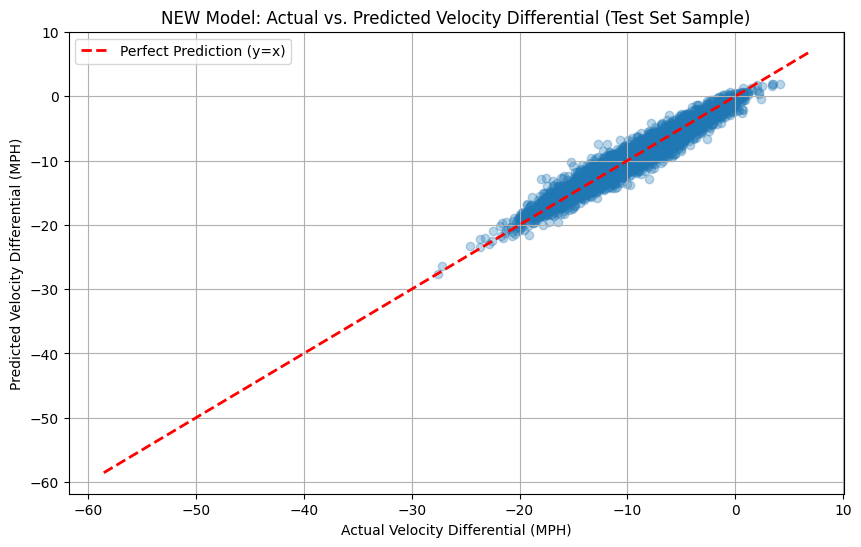

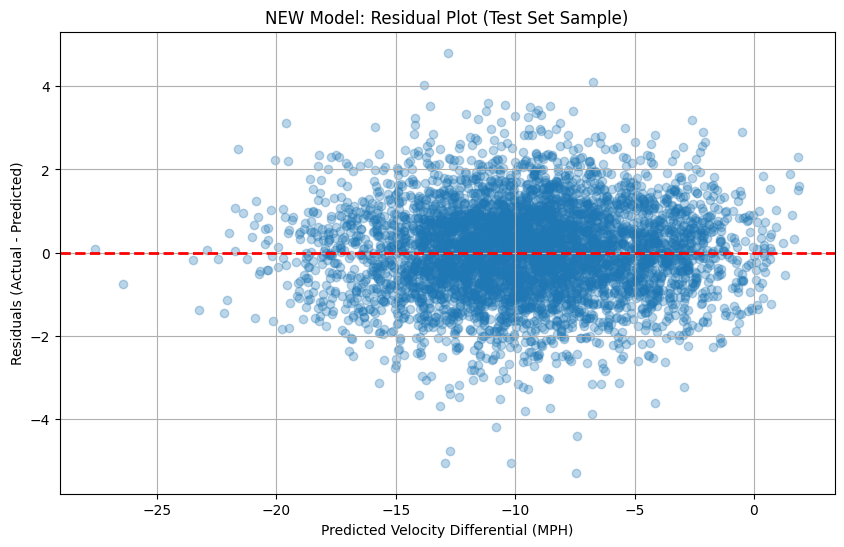


NEW Model: Top 15 Feature Importances:
                 Feature  Importance
12         break_delta_z    0.677843
14         pitch_type_CT    0.086611
0            avg_ff_velo    0.073432
10  spin_direction_delta    0.033291
5              release_z    0.015789
1              spin_rate    0.013112
6        release_delta_x    0.012545
4              release_x    0.012520
9        spin_rate_ratio    0.011021
18         pitch_type_SW    0.010560
3                break_x    0.010397
11         break_delta_x    0.009757
7        release_delta_z    0.009712
2         spin_direction    0.009563
8        spin_rate_delta    0.009555


<ipython-input-37-f8643fb1d596>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_new.head(15), palette='viridis')


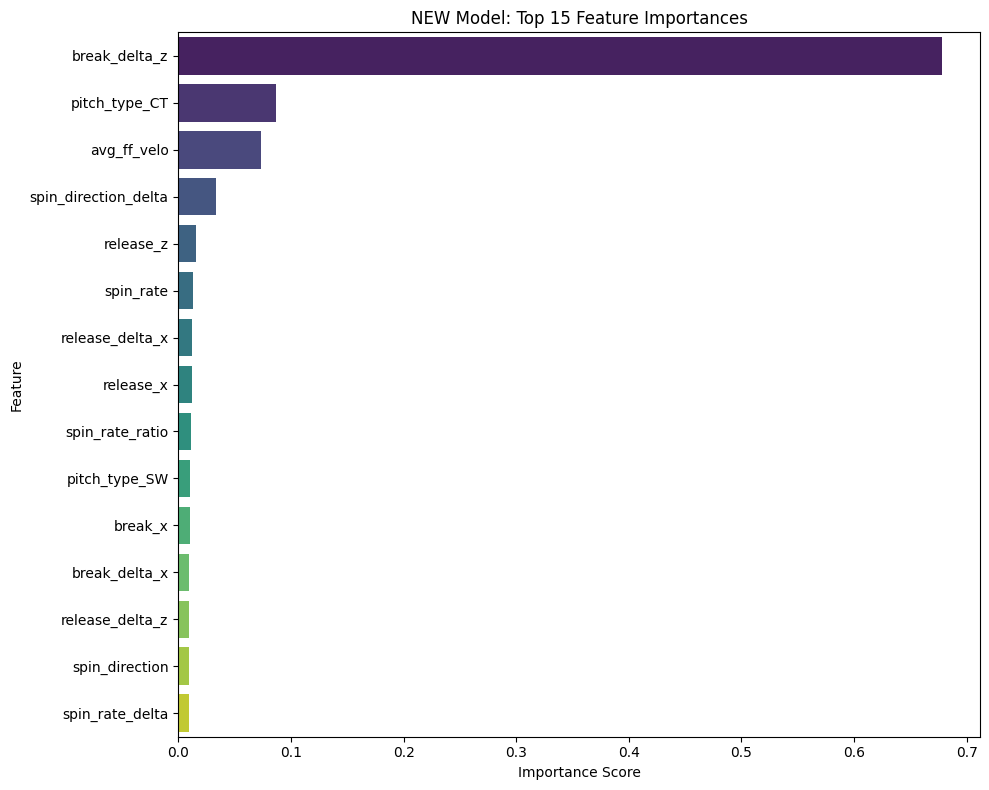


NEW Model: Percentage of predictions within +/- 2.0 MPH of actual: 93.32%
NEW Model: Percentage of predictions within +/- 1.0 MPH of actual: 66.75%


In [37]:
# Visualizations
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
sample_indices_new = np.random.choice(X_test_new.index, size=min(5000, len(X_test_new)), replace=False)
plt.scatter(y_test_new.loc[sample_indices_new], y_pred_new[X_test_new.index.get_indexer(sample_indices_new)], alpha=0.3)
plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], '--', color='red', lw=2, label='Perfect Prediction (y=x)')
plt.xlabel("Actual Velocity Differential (MPH)")
plt.ylabel("Predicted Velocity Differential (MPH)")
plt.title("NEW Model: Actual vs. Predicted Velocity Differential (Test Set Sample)")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
residuals_new = y_test_new - y_pred_new
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_new[X_test_new.index.get_indexer(sample_indices_new)], residuals_new.loc[sample_indices_new], alpha=0.3)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Velocity Differential (MPH)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("NEW Model: Residual Plot (Test Set Sample)")
plt.grid(True)
plt.show()

# Feature Importance Plot
importances_new = rf_model_new.feature_importances_
feature_names_new = X_processed_new.columns
feature_importance_df_new = pd.DataFrame({'Feature': feature_names_new, 'Importance': importances_new})
feature_importance_df_new = feature_importance_df_new.sort_values(by='Importance', ascending=False)

print("\nNEW Model: Top 15 Feature Importances:")
print(feature_importance_df_new.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_new.head(15), palette='viridis')
plt.title('NEW Model: Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Accuracy Check
margin = 2.0
percentage_within_margin_new = (np.sum(np.abs(residuals_new) <= margin) / len(y_test_new)) * 100
print(f"\nNEW Model: Percentage of predictions within +/- {margin} MPH of actual: {percentage_within_margin_new:.2f}%")
margin = 1.0
percentage_within_margin_1_new = (np.sum(np.abs(residuals_new) <= margin) / len(y_test_new)) * 100
print(f"NEW Model: Percentage of predictions within +/- {margin} MPH of actual: {percentage_within_margin_1_new:.2f}%")

# Model Evaluation: Old vs New

## Test Set Evaluation Metrics:
  
  Mean Absolute Error (MAE):      0.8430 (MPH difference)

  Root Mean Squared Error (RMSE): 1.1845 (MPH difference)
  
  R-squared (R²):                 0.9371



## New Test Set Evaluation Metrics:
  
  New Test Set Evaluation Metrics:

  Mean Absolute Error (MAE):      0.8460 (MPH difference)
  
  Root Mean Squared Error (RMSE): 1.1938 (MPH difference)
  
  R-squared (R²):                 0.9366


## Comparison:
  
  MAE Change:  0.0030
  
  RMSE Change: 0.0093
  
  R² Change:   -0.0005


--- Analyzing Outlier Characteristics ---

Pitchers with most large errors (in top N):
pitcher
Dany Jimenez       3
Kevin Gausman      2
Aaron Civale       2
Andrew Vasquez     2
Michael Kopech     1
Greg Weissert      1
Francisco Mejia    1
Logan Allen        1
Zach Thompson      1
Matt Magill        1
Shohei Ohtani      1
Jon Gray           1
Austin Voth        1
Nick Maton         1
Logan Gilbert      1
Name: count, dtype: int64

Pitch types with most large errors (in top N):
pitch_type
SL    9
CB    6
CT    4
SW    1
Name: count, dtype: int64

Distribution of 'break_delta_z' for large errors vs. all test samples:


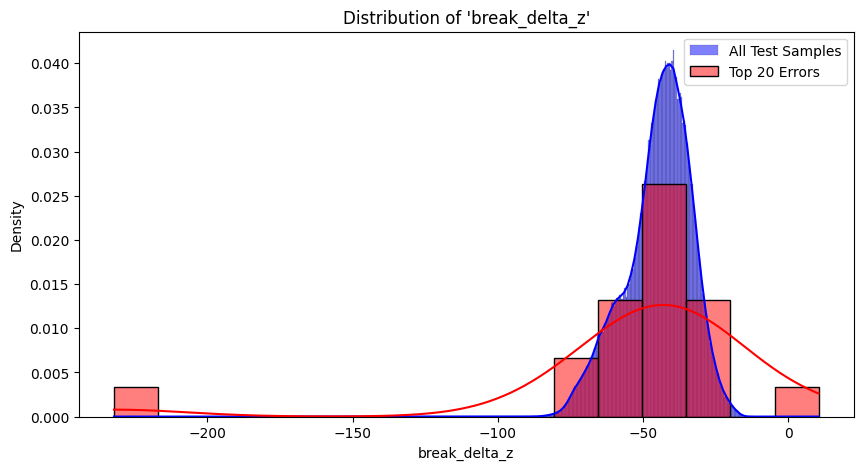


Number of large overpredictions (predicted higher velo diff): 16
Number of large underpredictions (predicted lower velo diff): 4

--- Top 20 Largest Prediction Errors ---


,pitcher,pitch_type,release_velo,avg_ff_velo,actual_diff,predicted_diff,residual,break_delta_z,spin_rate_delta,release_delta_x,release_delta_z,avg_ff_break_z,break_z,spin_rate,avg_ff_spin_rate,spin_direction,avg_ff_spin_direction,spin_direction_delta,break_x,avg_ff_break_x,break_delta_x
2759208,Greg Weissert,SL,35.4276,93.969708,-58.542108,-42.552704,-15.989403,-232.177743,1109.557457,-1.692943,-0.380743,5.073743,-227.1040,1114.63120,5.073743,101.4247,5.073743,96.350957,-15.4971,5.073743,-20.570843
1533405,Francisco Mejia,SL,59.1624,92.020400,-32.858000,-18.150811,-14.707189,-66.450600,1539.134200,-4.610000,0.596200,5.851800,-60.5988,1544.98600,5.851800,188.7855,5.851800,177.066300,0.9919,5.851800,-4.859900
1800264,Aaron Civale,CB,65.6268,91.895118,-26.268318,-14.139523,-12.128794,-51.997571,2541.061479,-17.828871,-1.145671,6.196971,-45.8006,2547.25845,6.196971,164.8042,6.196971,158.607229,4.0074,6.196971,-2.189571
1877348,Michael Kopech,SL,60.3973,96.147050,-35.749750,-25.816902,-9.932848,-80.019986,2495.654714,-3.149986,0.389414,5.779486,-74.2405,2501.43420,5.779486,211.0790,5.779486,154.700486,-5.0062,5.779486,-10.785686
1935965,Matt Magill,CB,80.3121,91.854607,-11.542507,-20.259005,8.716498,-56.006391,698.296409,-3.796291,0.222809,6.019691,-49.9867,704.31610,6.019691,189.7398,6.019691,176.279891,0.5772,6.019691,-5.442491
2374171,Aaron Civale,SL,75.6017,91.895118,-16.293418,-7.758228,-8.535189,-41.740171,2409.273129,-6.296371,-0.426471,6.196971,-35.5432,2415.47010,6.196971,197.6156,6.196971,168.581371,18.0867,6.196971,11.889729
1731439,Zach Thompson,CT,82.6030,91.762121,-9.159121,-0.732728,-8.426393,10.473421,2265.339121,-6.098879,0.876821,6.631579,17.1050,2271.97070,6.631579,205.1887,6.631579,161.442879,-10.4539,6.631579,-17.085479
1461545,Logan Allen,CT,78.9638,92.264050,-13.300250,-5.077989,-8.222261,-35.760734,827.215766,-7.649534,-0.268534,6.164934,-29.5958,833.38070,6.164934,126.0620,6.164934,119.897066,-3.4631,6.164934,-9.628034
2363681,Shohei Ohtani,CT,78.8723,96.375772,-17.503472,-9.498747,-8.004725,-39.819650,2299.264550,-3.640650,-0.200250,5.886250,-33.9334,2305.15080,5.886250,92.8042,5.886250,86.917950,-5.3024,5.886250,-11.188650
1837214,Kevin Gausman,SW,75.4982,94.541162,-19.042962,-11.191225,-7.851736,-42.313823,2343.049877,-3.211523,-0.313023,5.901323,-36.4125,2348.95120,5.901323,126.3159,5.901323,120.414577,-7.6955,5.901323,-13.596823


In [38]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

if 'residuals_new' not in locals():
    residuals_new = y_test_new - y_pred_new

# Add residuals and predicted values to a temporary DataFrame for easier analysis
df_test_results = pd.DataFrame({
    'actual_diff': y_test_new,
    'predicted_diff': y_pred_new,
    'residual': residuals_new,
    'abs_residual': np.abs(residuals_new)
})

# Merge with original features and pitcher info from df_target_enriched
df_test_full_info = df_target_enriched.loc[X_test_new.index].copy()
df_test_with_errors = pd.concat([df_test_full_info,
                                 df_test_results.set_index(X_test_new.index)], axis=1)

# define what constitutes a "large error" - e.g., top N errors or errors above a threshold
n_top_errors = 20
df_large_errors = df_test_with_errors.nlargest(n_top_errors, 'abs_residual')



# Identify outliers
# Select columns relevant for understanding the error
cols_to_show = ['pitcher', 'pitch_type', 'release_velo', 'avg_ff_velo',
                'actual_diff', 'predicted_diff', 'residual',
                'break_delta_z', 'spin_rate_delta', 'release_delta_x', 'release_delta_z',
                'avg_ff_break_z', 'break_z', 'spin_rate', 'avg_ff_spin_rate',
                'spin_direction', 'avg_ff_spin_direction', 'spin_direction_delta',
                'break_x', 'avg_ff_break_x', 'break_delta_x' # Added more features
               ]
# Ensure all cols_to_show are actually in df_large_errors
cols_to_print = [col for col in cols_to_show if col in df_large_errors.columns]

# Analyze Characteristics of These Outliers
print("\n--- Analyzing Outlier Characteristics ---")

# 1. Pitcher Concentration:
print("\nPitchers with most large errors (in top N):")
print(df_large_errors['pitcher'].value_counts())

# 2. Pitch Type Concentration:
print("\nPitch types with most large errors (in top N):")
print(df_large_errors['pitch_type'].value_counts())

# 3. Feature Value Exploration (Example: break_delta_z)
print("\nDistribution of 'break_delta_z' for large errors vs. all test samples:")
plt.figure(figsize=(10, 5))
sns.histplot(df_test_with_errors['break_delta_z'], color="blue", label='All Test Samples', kde=True, stat="density", common_norm=False)
sns.histplot(df_large_errors['break_delta_z'], color="red", label=f'Top {n_top_errors} Errors', kde=True, stat="density", common_norm=False)
plt.title("Distribution of 'break_delta_z'")
plt.legend()
plt.show()

# 4. Direction of error
overpredictions = df_large_errors[df_large_errors['residual'] < 0] # Predicted was higher (less negative) than actual
underpredictions = df_large_errors[df_large_errors['residual'] > 0] # Predicted was lower (more negative) than actual
print(f"\nNumber of large overpredictions (predicted higher velo diff): {len(overpredictions)}")
print(f"Number of large underpredictions (predicted lower velo diff): {len(underpredictions)}")

# Print the table with largest errors only once at the end
print(f"\n--- Top {n_top_errors} Largest Prediction Errors ---")
df_large_errors[cols_to_print]

In [39]:
features_to_inspect = [
    'break_delta_z', 'spin_rate_delta', 'release_delta_x', 'release_delta_z',
    'spin_direction_delta', 'break_delta_x',
    'spin_rate_ratio', # Also a relative feature
    'actual_diff'
]


--- Overlayed KDE Plots: Large Errors vs. All Test Samples ---


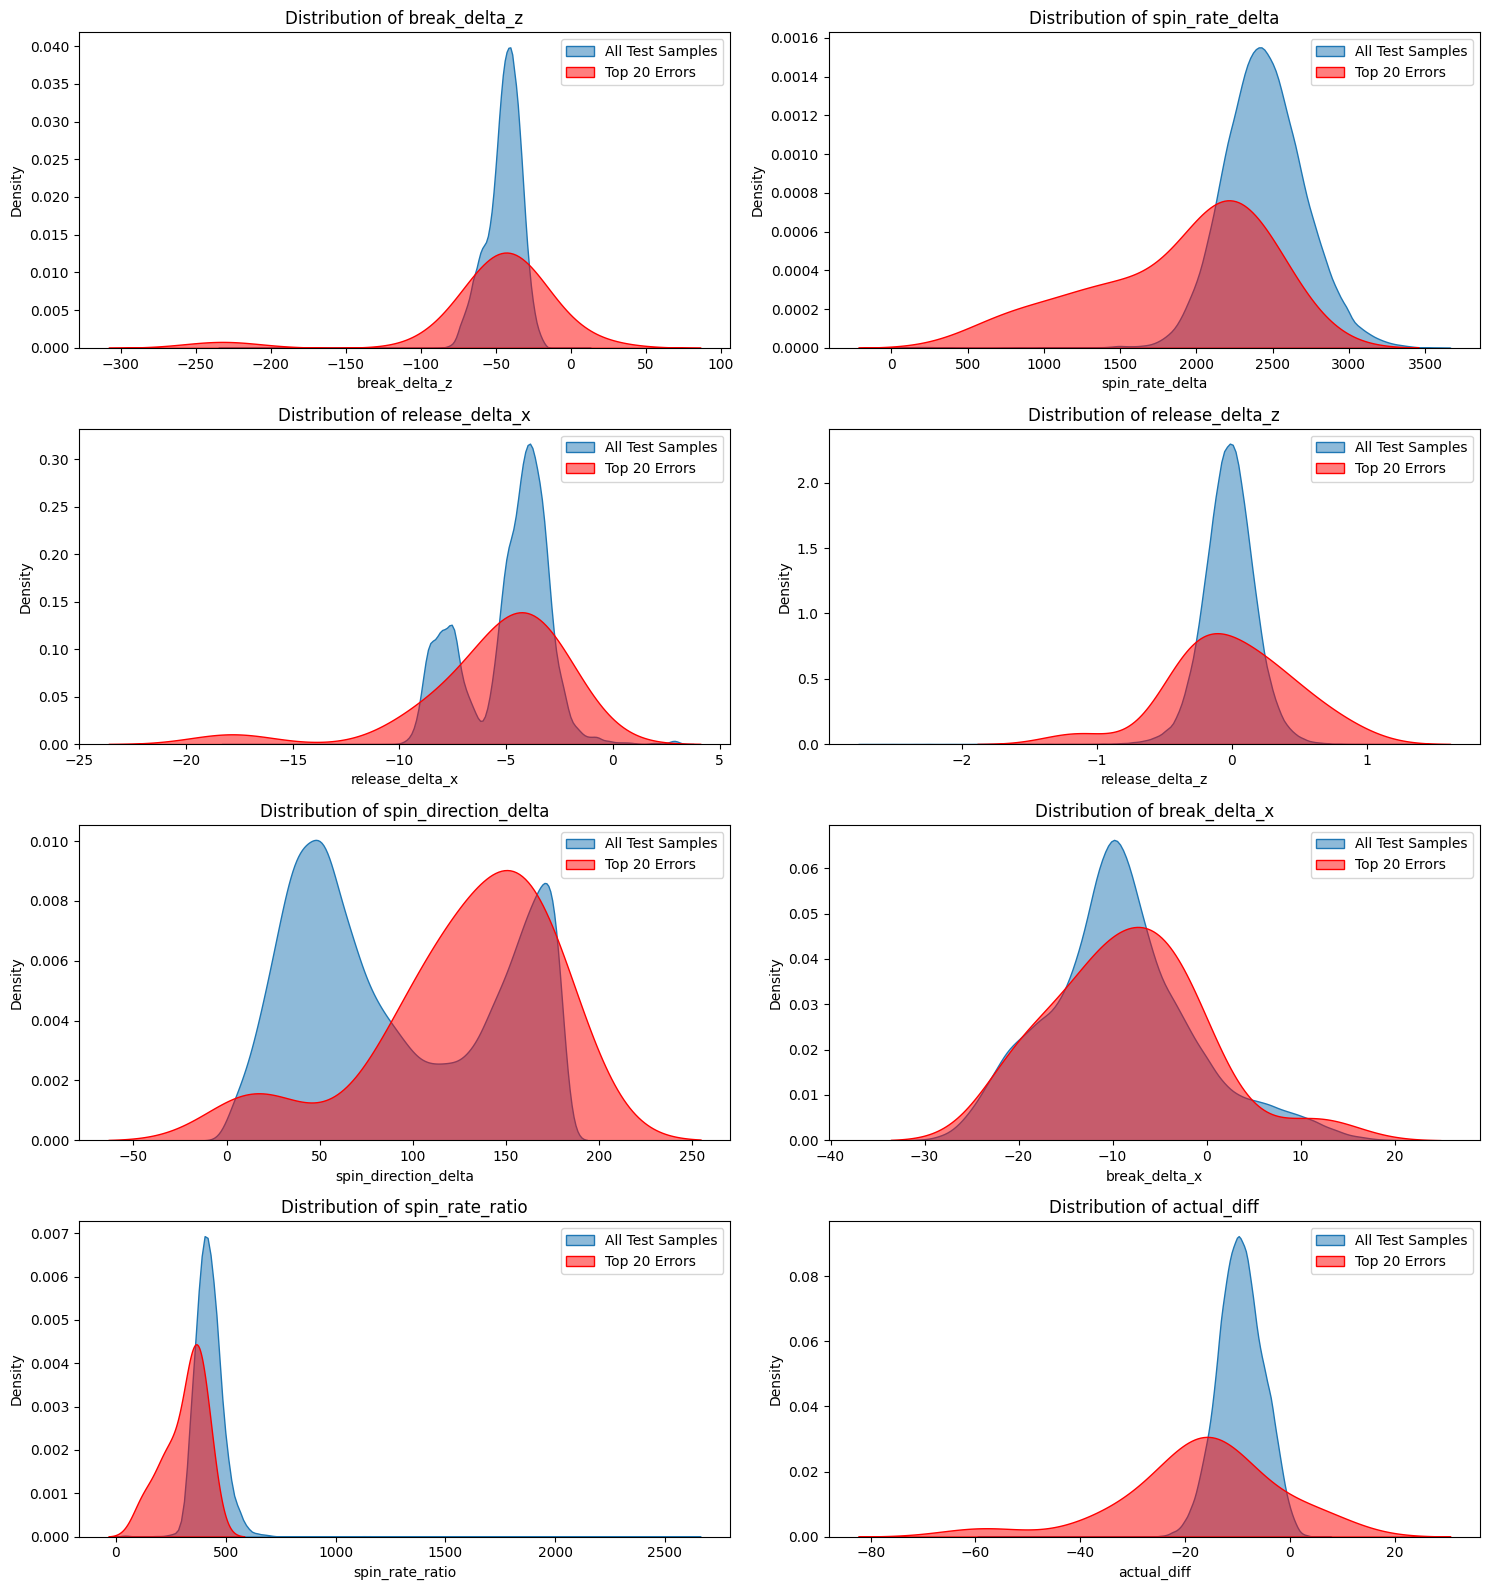

In [40]:
# compare distribution in 'df_large_errors' vs. 'df_test_with_errors'

print("\n--- Overlayed KDE Plots: Large Errors vs. All Test Samples ---")
num_features_inspect = len(features_to_inspect)
fig_kde, axes_kde = plt.subplots(int(np.ceil(num_features_inspect / 2)), 2,
                                 figsize=(15, 4 * int(np.ceil(num_features_inspect / 2))))
axes_kde = axes_kde.flatten()

for i, feature in enumerate(features_to_inspect):
    if feature not in df_test_with_errors.columns:
        print(f"Feature '{feature}' not found, skipping KDE plot.")
        if i < len(axes_kde): axes_kde[i].set_visible(False)
        continue

    sns.kdeplot(df_test_with_errors[feature], ax=axes_kde[i], label='All Test Samples', fill=True, alpha=0.5)
    sns.kdeplot(df_large_errors[feature], ax=axes_kde[i], label=f'Top {n_top_errors} Errors', fill=True, alpha=0.5, color='red')
    axes_kde[i].set_title(f'Distribution of {feature}')
    axes_kde[i].legend()

for j in range(i + 1, len(axes_kde)):
    fig_kde.delaxes(axes_kde[j])

plt.tight_layout()
plt.show()

# XGBOOST

In [41]:
import xgboost as xgb
import time


#Initialize XGBoost Model with correct parameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse",
    early_stopping_rounds=10
)

eval_set = [(X_train_new, y_train_new), (X_test_new, y_test_new)]

start_time = time.time()
xgb_model.fit(
    X_train_new, y_train_new,
    eval_set=eval_set,
    verbose=False
)
end_time = time.time()
xgb_training_time = end_time - start_time

print(f"XGBoost training completed in {xgb_training_time:.2f} seconds.")
if hasattr(xgb_model, "best_iteration"):
    print(f"Best iteration found at: {xgb_model.best_iteration} rounds (due to early stopping)")



--- Training XGBoost Regressor ---
XGBoost training completed in 8.24 seconds.
Best iteration found at: 99 rounds (due to early stopping)


In [42]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test_new)

In [43]:
# Evaluate XGBoost Model
print("\n--- XGBoost Model Evaluation Metrics ---")
mae_xgb = mean_absolute_error(y_test_new, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_new, y_pred_xgb))  # Calculate RMSE manually
r2_xgb = r2_score(y_test_new, y_pred_xgb)

print(f"  Mean Absolute Error (MAE):      {mae_xgb:.4f} (MPH difference)")
print(f"  Root Mean Squared Error (RMSE): {rmse_xgb:.4f} (MPH difference)")
print(f"  R-squared (R²):                 {r2_xgb:.4f}")

# Compare with previous Random Forest results
if 'mae_new' in locals() and 'rmse_new' in locals() and 'r2_new' in locals():
    print("\n--- Comparison with Feature-Engineered Random Forest ---")
    print(f"XGBoost vs RF MAE Change:  {mae_xgb - mae_new:.4f}")
    print(f"XGBoost vs RF RMSE Change: {rmse_xgb - rmse_new:.4f}")
    print(f"XGBoost vs RF R² Change:   {r2_xgb - r2_new:.4f}")
else:
    print("\nPrevious Random Forest (rf_model_new) metrics not available for comparison.")


--- XGBoost Model Evaluation Metrics ---
  Mean Absolute Error (MAE):      1.1335 (MPH difference)
  Root Mean Squared Error (RMSE): 1.4447 (MPH difference)
  R-squared (R²):                 0.8891

--- Comparison with Feature-Engineered Random Forest ---
XGBoost vs RF MAE Change:  0.2875
XGBoost vs RF RMSE Change: 0.2508
XGBoost vs RF R² Change:   -0.0475


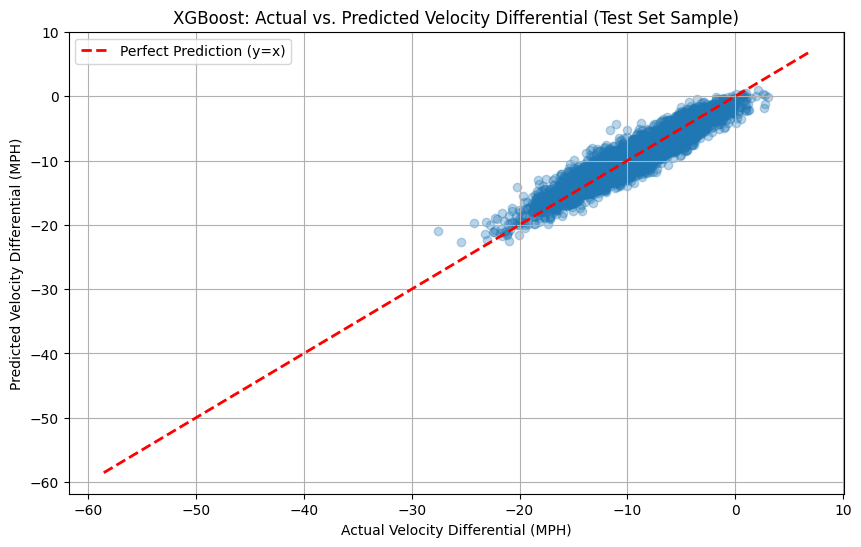

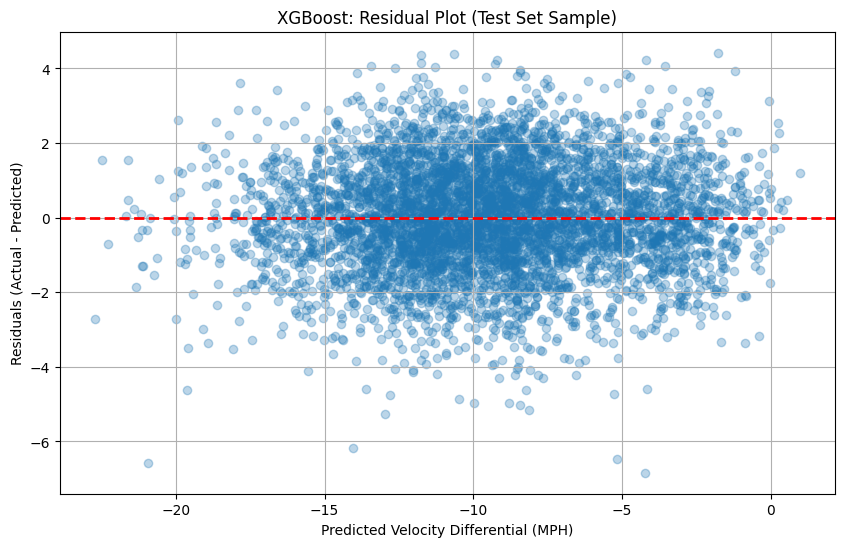

In [44]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
sample_indices_xgb = np.random.choice(len(X_test_new), size=min(5000, len(X_test_new)), replace=False)
plt.scatter(y_test_new.iloc[sample_indices_xgb], y_pred_xgb[sample_indices_xgb], alpha=0.3)
plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], '--', color='red', lw=2, label='Perfect Prediction (y=x)')
plt.xlabel("Actual Velocity Differential (MPH)")
plt.ylabel("Predicted Velocity Differential (MPH)")
plt.title("XGBoost: Actual vs. Predicted Velocity Differential (Test Set Sample)")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
residuals_xgb = y_test_new - y_pred_xgb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb[sample_indices_xgb], residuals_xgb.iloc[sample_indices_xgb], alpha=0.3)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Velocity Differential (MPH)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("XGBoost: Residual Plot (Test Set Sample)")
plt.grid(True)
plt.show()


--- XGBoost: Top 15 Feature Importances ---
                 Feature  Importance
14         pitch_type_CT    0.426261
12         break_delta_z    0.299623
10  spin_direction_delta    0.068137
13         pitch_type_CB    0.062881
18         pitch_type_SW    0.042608
3                break_x    0.017980
0            avg_ff_velo    0.012846
11         break_delta_x    0.011038
16         pitch_type_SL    0.009620
1              spin_rate    0.009548
8        spin_rate_delta    0.007745
5              release_z    0.006092
2         spin_direction    0.005573
7        release_delta_z    0.004166
4              release_x    0.004074


<ipython-input-45-5274c46ddb91>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb.head(15), palette='viridis')


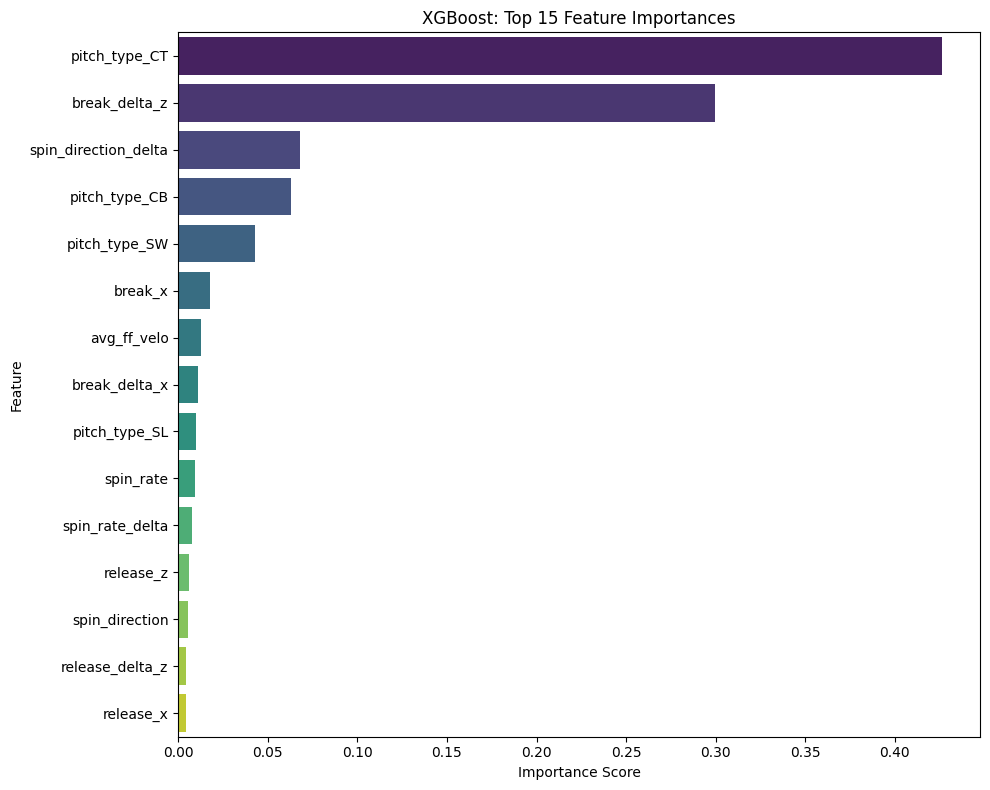

In [45]:
# XGBoost Feature Importance
# Ensure X_processed_new columns are available for feature names
if 'X_processed_new' not in locals():
    print("Warning: X_processed_new (for feature names) not found. Feature importances might be hard to interpret.")
    feature_names_xgb = [f"f{i}" for i in range(X_train_new.shape[1])]
else:
    feature_names_xgb = X_processed_new.columns

importances_xgb = xgb_model.feature_importances_
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': importances_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

print("\n--- XGBoost: Top 15 Feature Importances ---")
print(feature_importance_df_xgb.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb.head(15), palette='viridis')
plt.title('XGBoost: Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Model Evaluation: XGBoost vs RF Feature Engineered

## --- XGBoost Model Evaluation Metrics ---
  
  Mean Absolute Error (MAE):      1.1335 (MPH difference)
  
  Root Mean Squared Error (RMSE): 1.4447 (MPH difference)
  
  R-squared (R²):                 0.8891


## --- Comparison with Feature-Engineered Random Forest ---

XGBoost vs RF MAE Change:  0.2875

XGBoost vs RF RMSE Change: 0.2508

XGBoost vs RF R² Change:   -0.0475

For validation rigor, I implemented an XGBoost model in parallel. The XGBoost model trained on the feature engineered dataset ultimately performed marginally worse than the RFR model while adding complexity and computational cost. While both models demonstrated exceptional predictive accuracy, the results underscored that thoughtful feature engineering was ultimately the decisive factor in the model success.

Despite the first RF model performing the best by the metrics, I would select the feature engineered model simply because of how much closer visually the predictions follow the optimal line. All three models are pretty good in these instances and don't wildly outperform each other, so the RF Feature Engineered model is my choice, given the lack of computational cost compared to XGBoost.

# Potential Improvements

1. Adjust the cleaning to drop the 21k rows with missing values rather than imputing medians could lead to more accurate predictions.

2. Separate data annualy to model year-to-year changes within pitcher repetoires, arsenals, mechanical changes, etc. Having the models look at single-season data would likely be more accurate.

in a future rendition of this project, I would test a model that more explicitly evaluates year-to-year changes in baseline fastball velocity. I do think that the amount of pitchers losing velocity due to age is counterbalanced by the younger pitchers increasing their velocity through development, but a model trained explicitly factoring pitcher age could show clearer changes in velocity differential from season to season.

# Analytical Findings

## Between both RF models:

The predictions and the residuals indicated a need for feature engineering to give the model additional context. Instead of looking at raw pitch data, the model should be looking at the difference in pitch data values between the fastball baseline and the breaking balls. This includes differentials for break, release point, spin rate, and spin axis. After creating those features and adding them back into the data frame, I re-trained the RFR and received much better predictions.
Both models revealed that the vertical break differential between breaking balls and primary fastballs emerged as the dominant predictive factor. This finding lines up with basic logic where curveballs have the most drop and sliders drop less but are often thrown much harder. 

Achieving a high R² of approximately 0.94 is promising, but with large datasets and complex models like Random Forest, it can’t hurt to consider overfitting. The out-of-bag score (0.9, close to test R²) provided some initial reassurance during RF training, but more rigorous validation techniques would be employed in a production setting. In future iterations, I would explore incorporating K-Fold Cross-Validation while tuning the RF model’s hyperparameters to ensure robust generalization.

# Enhancing the project

### Fatigue/Workload Metrics & Injury Forecasting: 
This model implicitly captures some effects of fatigue through raw pitch data, but explicit incorporation of more sophisticated workload indicators could be beneficial. To incorporate this effectively, you would need to distinguish between relievers and starters. Pitches thrown in the current inning, rolling averages of velocity/spin over recent appearances, and days of rest could capture nuances in the data. Such features might better explain variations in velocity differentials, particularly late in games or during a strenuous stretch of a full season. 

### Tailored Development: 
The model could establish data-driven baselines for expected velocity differentials based on a pitcher's mechanics, and deviations could guide player development efforts. If a pitcher's sweeper has a smaller differential than predicted given their change in break and release, coaches could investigate if there's potential to add more separation or if their current execution is optimal for their arm action. Combining a robust iteration of this model with direct biomechanical measurements (e.g., motion capture of arm speed, joint angles, kinetic chain sequencing) or more Hawkeye/Trackman data (e.g. spin axis decomposition, seam-shifted wake effects) has the potential to markedly improve pitch development and pitcher deception.

### Scouting Efficiency: 
This framework could flag amateur or minor league pitchers with outlier differential profiles (either exceptionally good or surprisingly small given their other metrics) for further in-person scouting to identify undervalued or unique skill sets.

### Exploring Pitch Sequencing: 
Future models could investigate the impact of pitch sequencing by using the preceding pitch movement, location, and velocity differential to optimize the swinging strike rate of breaking balls. This would likely improve the value of pitcher deception and repeatable mechanics, as well as the ability of catchers to call the correct pitch. 